COPY FROM t1 FOLDER: change input to have time-dependency and add LSTM model

Search for "FIXME" for tunable parameters

## Import libraries

In [1]:
print("load libraries")
import numpy as np
from sklearn.decomposition import PCA
import utils

# https://stackoverflow.com/a/34306306/4126114
np.random.seed(0)

load libraries


Using TensorFlow backend.


## Generate data

(10000, 5)
X [[ 0.5282081   0.49139665  0.87688119  0.72406159  0.17908103]
 [ 0.50957763  0.52991413  0.88207362  0.75294198  0.18281902]
 [ 0.59425967  0.63044742  0.86875689  0.80547866  0.29426954]
 [ 0.65864441  0.66015107  0.94499635  0.89540051  0.37645864]
 [ 0.50714055  0.64015348  0.82920285  0.77535441  0.22628521]
 [ 0.62351648  0.70164731  0.86606032  0.84785567  0.36617593]
 [ 0.76337367  0.67847964  0.89027716  0.85624053  0.51766671]
 [ 0.73583423  0.74838171  0.7952485   0.8059884   0.54375932]
 [ 0.68624915  0.69723695  0.70314708  0.68800169  0.43507744]
 [ 0.72695191  0.75248471  0.82541047  0.8387988   0.53472701]]


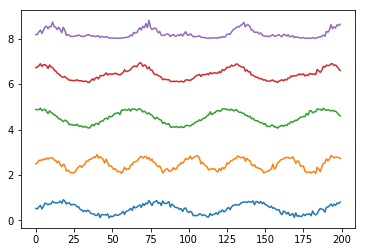

In [40]:
N=int(1e4) # FIXME 1e5

# Try dataset from https://stats.stackexchange.com/questions/190148/autoencoder-pca-tensorflow?rq=1
from sklearn.preprocessing import scale
def data1(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

X = data1(N)

print(X.shape)
print('X',X[0:10,:])

utils.myPlot(X,2)

## Try PCA

PCA
n_components =  5
err pca =  1.36074972355e-15
Explained variance ratio (cumsum) [ 0.51511562  0.79349437  0.98865382  0.99654388  1.        ]


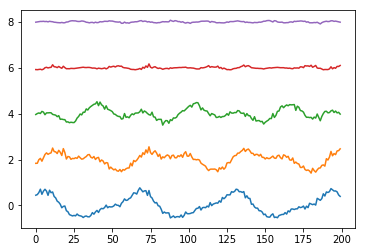

In [41]:
N_epochs = 25
n_c_i = 5
print("PCA")
pca = PCA(n_components=n_c_i, random_state=888, svd_solver = 'full')
X_pca = pca.fit_transform(X)
# print("X_pca_0",X_pca_0[0:10,:])
# print("")
# print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# print("")
print("n_components = ",n_c_i)
utils.pca_err(X, X_pca)
print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# plot
utils.myPlot(X_pca,2)


## Try AE7, AE10, AE15, AE20, AE25

autoencoder
n_components =  15


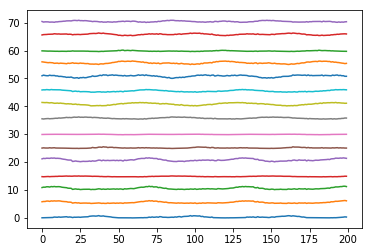

AE1 mse =  0.0209510411157


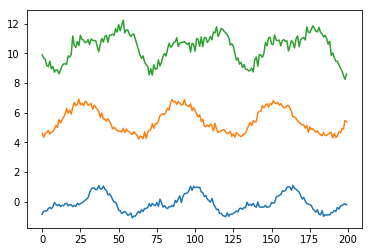

AE2 mse =  0.0325713322556


In [4]:
print("autoencoder")
N_epochs = 25
for n_c_i in [15]: # [7,10,15,20,25]: # 'mle'
    print("n_components = ",n_c_i)
    autoencoder, encoder = utils.buildNetwork(X.shape[1], encoding_dim_ae = n_c_i)
    X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
    print("AE1 mse = ", utils.mse(X, X_rec))
    autoencoder, encoder = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3)
    X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
    print("AE2 mse = ", utils.mse(X, X_rec))



## USE lstm-based autoencoder

In [69]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.layers.advanced_activations import LeakyReLU #, PReLU

in_neurons = X.shape[1]
print(in_neurons)
out_neurons = in_neurons
hidden_neurons = 25
# set below by judging by the crescents of the sin and cos in data generation
# look back = 50 with hidden neurons = 25 => MSE = 0.008
# look back = 100 with hidden neurons = 25 => MSE = 0.05
# ditty with enc_dim = 3 => MSE = ?
# BUT PERHAPS MEASURING WITH MSE LIKE THIS IS NOT GOOD
# BECAUSE I SEE THAT THE PREDICTED SIGNAL IS LAGGED
# I PROBABLY NEED SOME ALIGNMENT BEFORE CALCULATING MSE
look_back = 100 # FIXME
enc_dim = 3 # FIXME

autoencoder = Sequential()

# combined from Simple_LSTM_keras_2 and LSTM book, chap 9, seq2seq
autoencoder.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, in_neurons)))

# FIXME
# encoder layer
autoencoder.add(Dense(enc_dim, activation='linear'))
autoencoder.add(LeakyReLU(alpha=.3))

autoencoder.add(RepeatVector(look_back))
autoencoder.add(LSTM(hidden_neurons, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(out_neurons, activation='linear')))

autoencoder.compile(loss="mean_squared_error", optimizer="rmsprop")

autoencoder.summary()
#--------------------
print('-'*10)
from keras.models import Model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
encoder.compile(loss="mean_squared_error", optimizer="rmsprop")
encoder.summary()

5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 25)                3100      
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 78        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 100, 3)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 25)           2900      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 100, 5)            130       
Total params: 6,208
Trainable params: 6,208
Non-trainable params: 0
_________________________________________________________________
------

In [56]:
# https://stackoverflow.com/a/21230438/4126114
# Testing:
#    running_view(np.array([1,2,3,4,5,6,7,8,9,10]),3,0)
#    running_view(np.array([[1,2],[3,4],[5,6],[7,8],[9,10]]),3,0)
def running_view(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

def _load_data_strides(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """
    docX = running_view(data, n_prev, 0)
    docX = np.array([y.T for y in docX])
    return docX

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    #X_train, y_train = _load_data(df.iloc[0:ntrn], y.iloc[0:ntrn])
    #X_test, y_test = _load_data(df.iloc[ntrn:], y.iloc[ntrn:])
    # alternative to the for loop in the original load data
    # Note that both the original load data and the stride consume a lot of memory
    X_train = _load_data_strides(df[:ntrn,:], look_back)
    X_test = _load_data_strides(df[ntrn:,:], look_back)

    return (X_train), (X_test)

print('done')

done


(10000, 5) (8901, 100, 5) (901, 100, 5)


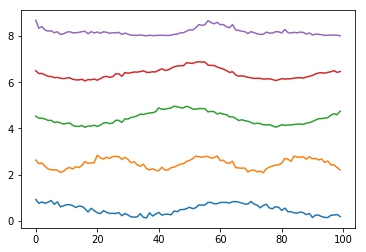

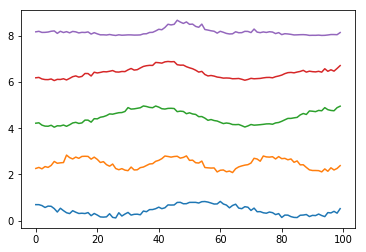

In [57]:
(X_train), (X_test) = train_test_split(X)  # retrieve data
print(X.shape, X_train.shape, X_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

utils.myPlot(X_test[0],2)
utils.myPlot(X_test[10],2)

In [70]:
epochs=10 # FIXME # 10
autoencoder.fit(X_train, X_train, batch_size=450, epochs=epochs, validation_split=0.05)

Train on 8455 samples, validate on 446 samples
Epoch 1/10
8455/8455 [==============================] - 30s - loss: 0.1333 - val_loss: 0.0601
Epoch 2/10
8455/8455 [==============================] - 28s - loss: 0.0588 - val_loss: 0.0572
Epoch 3/10
8455/8455 [==============================] - 26s - loss: 0.0574 - val_loss: 0.0560
Epoch 4/10
8455/8455 [==============================] - 25s - loss: 0.0565 - val_loss: 0.0556
Epoch 5/10
8455/8455 [==============================] - 24s - loss: 0.0558 - val_loss: 0.0547
Epoch 6/10
8455/8455 [==============================] - 24s - loss: 0.0551 - val_loss: 0.0541
Epoch 7/10
8455/8455 [==============================] - 24s - loss: 0.0547 - val_loss: 0.0542
Epoch 8/10
8455/8455 [==============================] - 24s - loss: 0.0544 - val_loss: 0.0536
Epoch 9/10
8455/8455 [==============================] - 24s - loss: 0.0540 - val_loss: 0.0531
Epoch 10/10
8455/8455 [==============================] - 24s - loss: 0.0538 - val_loss: 0.0529


1 (901, 100, 5) (901, 100, 5) 0.666996350113
2 (901, 100, 5) (901, 100, 5) 0.873313959118


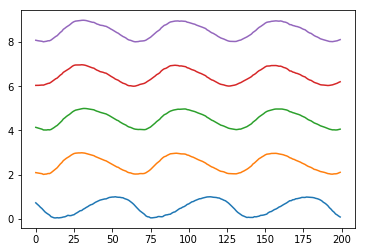

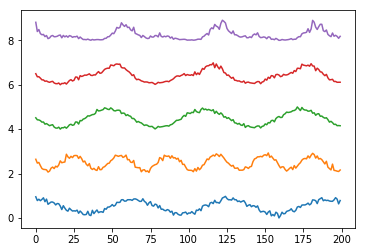

In [71]:
predicted = autoencoder.predict(X_test)  
rmse = utils.mse(X_test[:,0,:], predicted[:,0,:])
print(1, X_test.shape, predicted.shape, rmse)
rmse = utils.mse(utils.myNorm3(X_test[:,0,:]), utils.myNorm3(predicted[:,0,:]))
print(2, X_test.shape, predicted.shape, rmse)

#utils.myPlot(predicted[:,0,:],2)
#utils.myPlot(X_test[:,0,:],2)
utils.myPlot(utils.myNorm3(predicted[:,0,:]),2)
utils.myPlot(utils.myNorm3(X_test[:,0,:]),2)

(901, 100, 5) (901, 3)


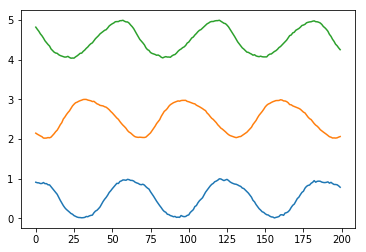

In [74]:
X_enc = encoder.predict(X_test)
print(X_test.shape, X_enc.shape)
utils.myPlot(utils.myNorm3(X_enc),2)